<a href="https://colab.research.google.com/github/UmarIgan/Machine-Learning/blob/master/Stable_Diffisuon_Fine_Tuning_With_Dreambooth_Autotrain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

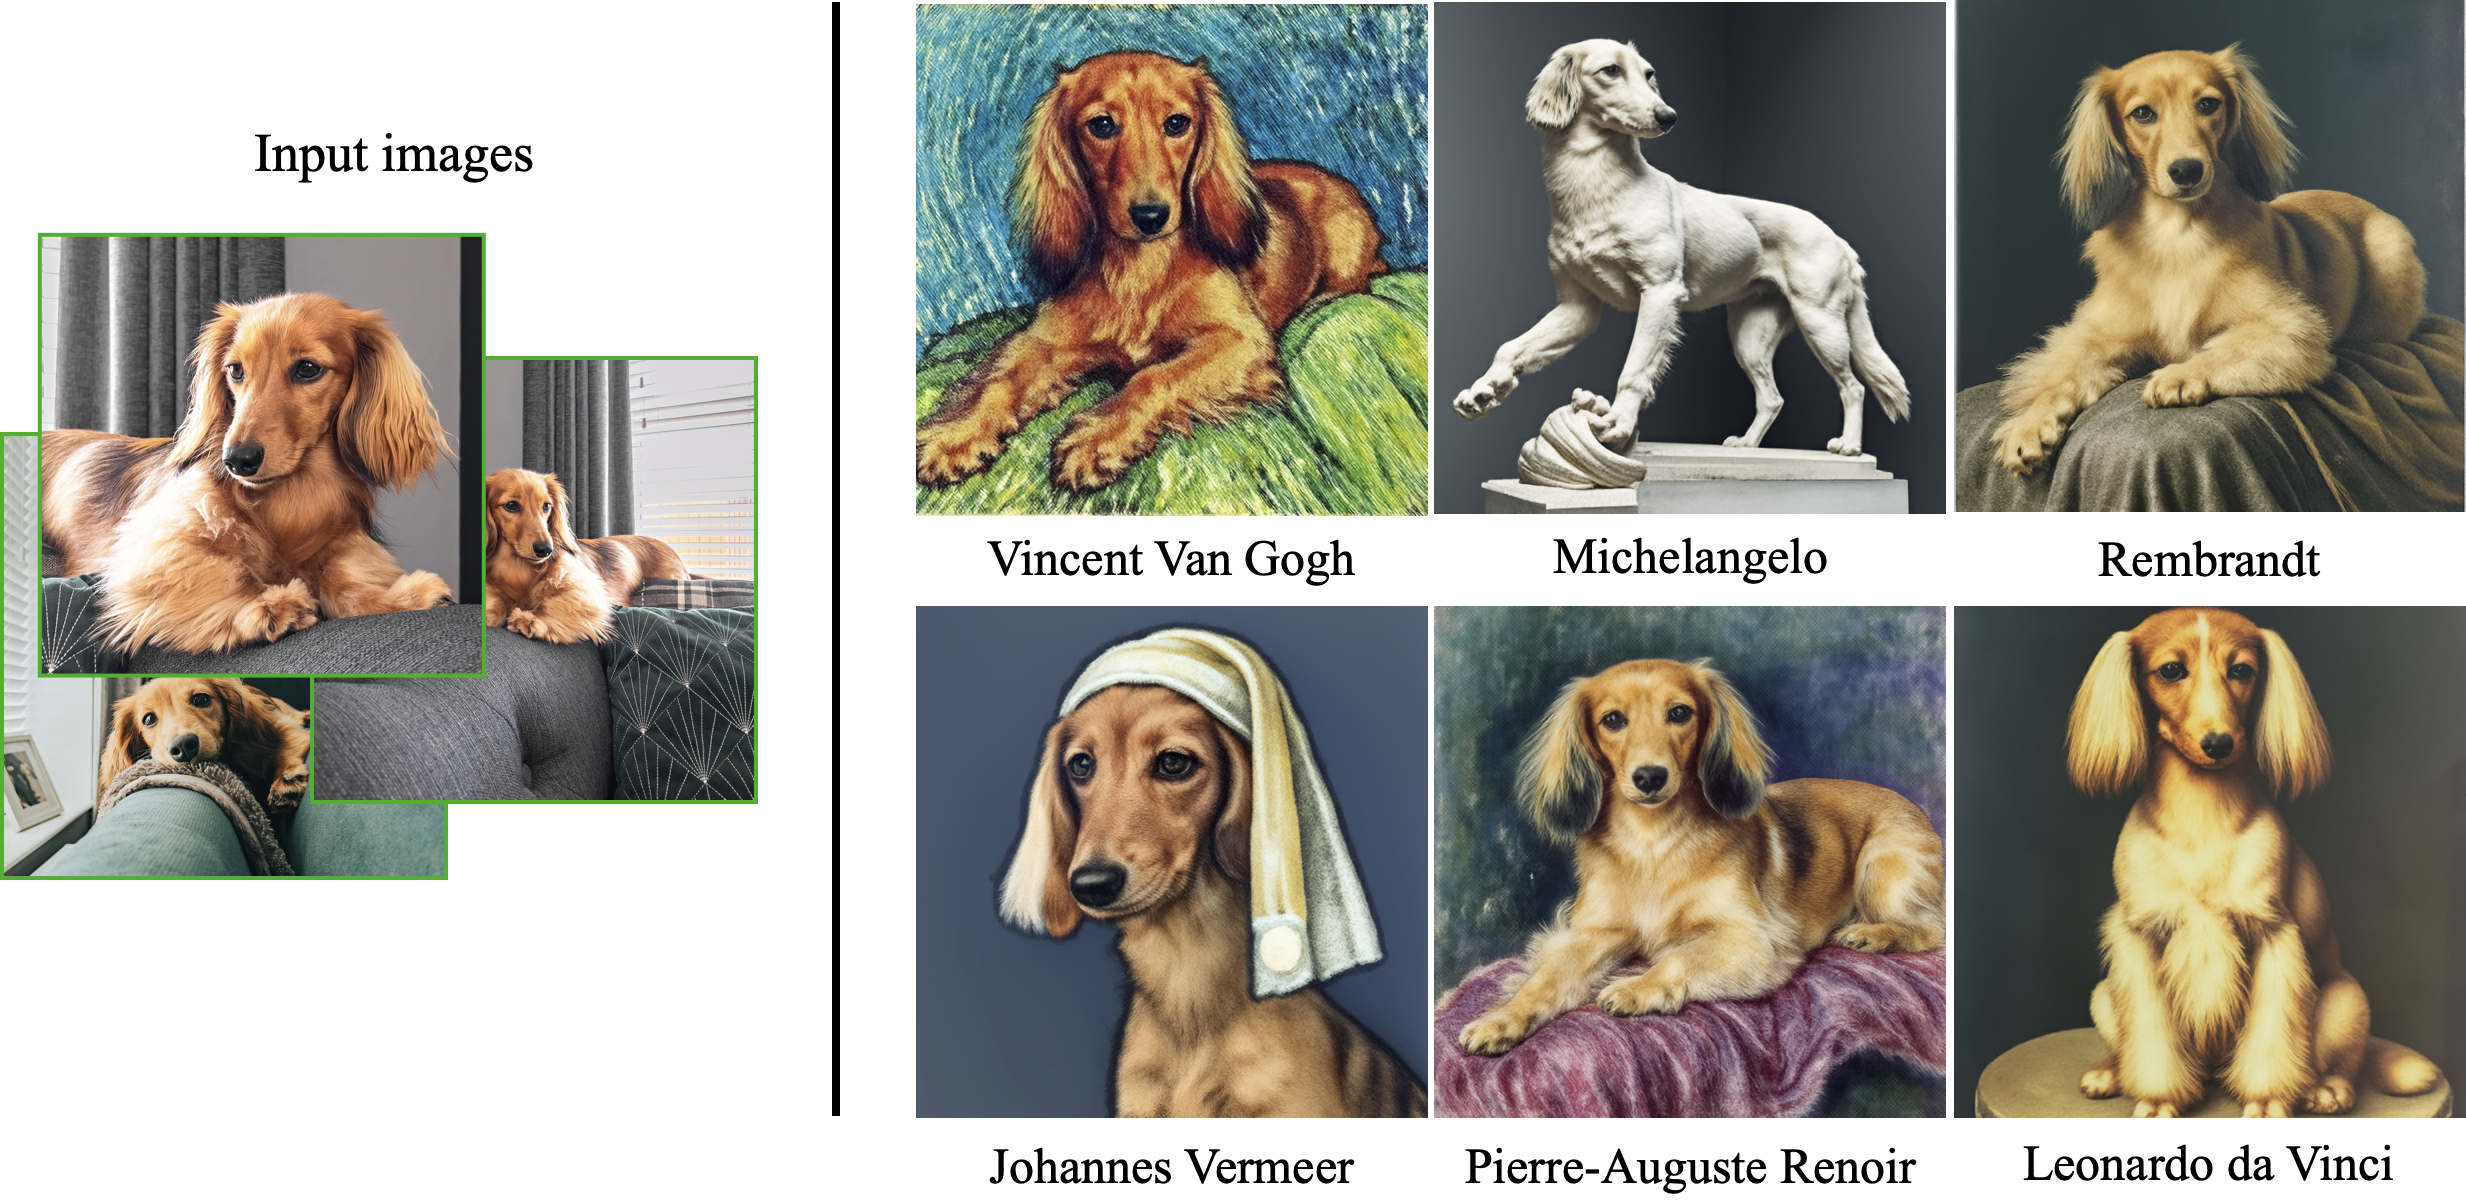

In [1]:
#@title fine-tuning Stable Diffusion using the Dreambooth method for personalized image generation with custom styles or objects
import requests
import IPython.display as Disp
url = 'https://dreambooth.github.io/DreamBooth_files/art.png'
Disp.Image(requests.get(url).content)

# **1. Setup**

In this notebook, I demonstrated a pipeline to fine-tuninig stable diffusion using dreamboth for person personalized image generation with custom styles or objects.
For faster demonstration, I used  high end Autotrain library. The reason I choosed this library is that it offers less coding while keeping parameter optimization possible


Once we setted up our image process, we can move on to installing libraries for our task, To not make too much noises in the notebook, We used logs methods for verboses.


We choosed to use ***AutoTrain Advanced*** by huggingface for this task. ***AutoTrain Advanced*** provides faster and easier training and deployments of state-of-the-art machine learning models.

with AutoTrain Advanced we can setup more readeble and updatable model pipeline for our task without sacrifying any step of deployment.

After installing autotrain-advanced we need to install requirements for packages which can be done with !autotrain setup command.



In [2]:
!pip install -U autotrain-advanced > install_logs.txt
!autotrain setup > setup_logs.txt

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.0.3 which is incompatible.
tensorflow-metadata 1.14.0 requires protobuf<4.21,>=3.20.3, but you have protobuf 4.23.4 which is incompatible.
> INFO    Installing latest transformers@main
> INFO    Successfully installed latest transformers
> INFO    Installing latest peft@main
> INFO    Successfully installed latest peft
> INFO    Installing latest diffusers@main
> INFO    Successfully installed latest diffusers
> INFO    Installing latest trl@main
> INFO    Successfully installed latest trl
> INFO    Installing latest xformers
> INFO    Successfully installed latest xformers


# **1. Datasets**

I first created a pipeline for loading images to our enviroment, Since this is a notebook We will receieve image urls and download them to our directory which we called image.
In a production enviroment, it might be changed based on needs.

#### **Requirements for High-Quality Training Datasets:**
High-quality training datasets are essential for the successful fine-tuning of Stable Diffusion using the Dreambooth method. Here are some requirements for such datasets:
- The dataset should encompass a wide range of objects and styles that are relevant to the task.

- A sufficient number of high-resolution images is required to train a stable diffusion model effectively.
- Images should be of high resolution to capture fine details. This is especially important for tasks that involve generating high-quality images.

- Depending on the task, annotations might be necessary. For object training, bounding boxes or segmentation masks can be helpful. For style training, labels or descriptions of styles may be required.

#### **Guidelines for collecting and preparing training images for object and style categories.**

- Dataset creation is the most important part of getting good, consistent results from Dreambooth training.
- Be sure to use high quality samples, as artifacts such as motion blur or low resolution will get picked up by the training and appear in the images you generate with your model.
- When training for a specific style, pick samples with good consistency. Ideally, only pick images from the show or artist you're training.
- Avoid fan art or anything with a different style, unless you're aiming for something like a style fusion.

#### **Instance Images and Class Images.**

**Instance Images**: These are individual images of specific objects or styles. For object training, each instance image represents a single object, and for style training, each instance image embodies a specific style. The model learns to generate instances similar to these images.

**Class Images**: Class images group instances by a shared characteristic. In object training, class images represent a category of objects (e.g., cats, dogs). In style training, class images might represent different art styles (e.g., impressionism, cubism). The model can learn to generate instances belonging to these classes.

Class images can help the model learn global characteristics of a category or style, while instance images help it capture fine-grained details.



---



In [3]:
urls_dogos= [
      "https://huggingface.co/datasets/valhalla/images/resolve/main/2.jpeg",
      "https://huggingface.co/datasets/valhalla/images/resolve/main/3.jpeg",
      "https://huggingface.co/datasets/valhalla/images/resolve/main/5.jpeg",
      "https://huggingface.co/datasets/valhalla/images/resolve/main/6.jpeg",
      ]
urls_animes = [
      "https://datasets-server.huggingface.co/assets/huggan/anime-faces/--/default/train/1/image/image.jpg",
      "https://datasets-server.huggingface.co/assets/huggan/anime-faces/--/default/train/2/image/image.jpg",
      "https://datasets-server.huggingface.co/assets/huggan/anime-faces/--/default/train/3/image/image.jpg",
      "https://datasets-server.huggingface.co/assets/huggan/anime-faces/--/default/train/4/image/image.jpg",
      ]
urls_cartoon = [
      "https://datasets-server.huggingface.co/assets/faterazer/LOL-Arts/--/faterazer--LOL-Arts/train/0/image/image.jpg",
      "https://datasets-server.huggingface.co/assets/faterazer/LOL-Arts/--/faterazer--LOL-Arts/train/1/image/image.jpg",
      "https://datasets-server.huggingface.co/assets/faterazer/LOL-Arts/--/faterazer--LOL-Arts/train/2/image/image.jpg",
      "https://datasets-server.huggingface.co/assets/faterazer/LOL-Arts/--/faterazer--LOL-Arts/train/3/image/image.jpg",
      ]

urls_art = ['https://datasets-server.huggingface.co/assets/keremberke/painting-style-classification/--/full/train/389/image/image.jpg',
            'https://datasets-server.huggingface.co/assets/keremberke/painting-style-classification/--/full/train/390/image/image.jpg',
            'https://datasets-server.huggingface.co/assets/keremberke/painting-style-classification/--/full/train/391/image/image.jpg',
            'https://datasets-server.huggingface.co/assets/keremberke/painting-style-classification/--/full/train/392/image/image.jpg',
            'https://datasets-server.huggingface.co/assets/keremberke/painting-style-classification/--/full/train/394/image/image.jpg',
            'https://datasets-server.huggingface.co/assets/keremberke/painting-style-classification/--/full/train/377/image/image.jpg',
            'https://datasets-server.huggingface.co/assets/keremberke/painting-style-classification/--/full/train/379/image/image.jpg'
            ]

In [8]:
import requests
import os
from PIL import Image
from io import BytesIO

def download_image(url):
    try:
        response = requests.get(url)
        response.raise_for_status()  # Raise an exception for invalid URLs or failed requests
    except Exception as e:
        print(f"Error downloading image: {e}")
        return None

    try:
        # Open the image, convert to RGB
        image = Image.open(BytesIO(response.content)).convert("RGB")
        return image
    except Exception as e:
        print(f"Error processing image: {e}")
        return None

images = [download_image(url) for url in urls_cartoon]

# Check if the 'images' directory exists, and if not, create it
save_path = "./images"
if not os.path.exists(save_path):
    os.mkdir(save_path)

# Save downloaded images
for i, image in enumerate(images):
    if image is not None:
        image.save(f"{save_path}/{i}.jpeg")


# **3. Training**
### Training a Stable Diffusion model using Dreambooth involves several key steps:
**Data Loading:** Load the prepared training dataset, which includes instance images for objects or styles. Ensure that the data loading pipeline includes preprocessing steps such as resizing, normalization, and data augmentation if necessary.

**Choosing Model**: An important ste could be to choose the right model, some model might be better for spesific task. For demonstration purpose, we will stick with most common one.

**Model Initialization**: Initialize the Stable Diffusion model architecture, including the generator and discriminator. You may use a pre-trained model as a starting point and fine-tune it on your specific dataset.

**Training Loop**: Implement a training loop that iteratively updates the model's weights. In each iteration, the generator and discriminator are updated based on their respective losses. Monitor training metrics, such as generator and discriminator losses, to assess convergence.

**Batch Size and Learning Rate** : Adjust the batch size and learning rate based on your specific dataset and hardware. Smaller batch sizes may require smaller learning rates to maintain stability.

#### Hyperparameters

1. **learning_rate = 1e-4:**
   - Learning rate determines the step size during the optimization process. A lower value like 1e-4 suggests a small step size, which can be suitable for stable and fine-grained convergence during training.

2. **num_steps = 300:**
   - This parameter indicates the total number of optimization steps during training. Training typically involves iteratively updating the model's weights for a fixed number of steps.

3. **batch_size = 1:**
   - Batch size defines the number of examples processed in each forward and backward pass during one training iteration. A batch size of 1 means that each training step processes a single example, which can be useful for stability but may result in longer training times.

4. **gradient_accumulation = 4:**
   - Gradient accumulation is a technique where gradients are accumulated over multiple mini-batches before performing a weight update. In this case, gradients are accumulated over 4 mini-batches before performing a weight update. It can be helpful when working with limited GPU memory.

5. **resolution = 512:**
   - Resolution refers to the size of the input images or the output images during training or inference. A resolution of 512 indicates that images of size 512x512 pixels are used. Make sure to fix resolution with size of your input images.

6. **use_8bit_adam = True:**
   - This parameter specifies whether to use an 8-bit version of the Adam optimizer. Using 8-bit precision can reduce memory usage and speed up training but may result in slightly less accurate updates.

7. **use_xformers = True:**
   - "Xformers" likely refers to Transformer-based architectures. Setting this parameter to True indicates that Transformer-like models or components are incorporated into the architecture.

8. **use_fp16 = True:**
   - FP16 (16-bit floating-point) training is a technique that uses reduced-precision floating-point numbers to speed up training and reduce memory usage. Setting this to True indicates that FP16 training is enabled.

9. **train_text_encoder = False:**
   - This parameter specifies whether to train the text encoder as part of the model. If set to False, it suggests that the text encoder is either pre-trained or fixed during training.

10. **gradient_checkpointing = True:**
    - Gradient checkpointing is a memory-saving technique that trades off computation time for reduced memory consumption during training. Setting this to True indicates that gradient checkpointing is used.

These parameters control various aspects of the training process, including optimization settings, model architecture, and memory management. The specific values and choices for these parameters can significantly impact the training dynamics and the quality of the resulting model.

In [9]:
project_name = 'umar'
model_name = "stabilityai/stable-diffusion-2"
prompt = 'a portrait of umar'

learning_rate = 1e-04
num_steps = 300
batch_size = 4
gradient_accumulation = 4
resolution = 512
use_8bit_adam = True
use_xformers = True
use_fp16 = True
train_text_encoder = False
gradient_checkpointing = True

os.environ["PROJECT_NAME"] = project_name
os.environ["MODEL_NAME"] = model_name
os.environ["PROMPT"] = prompt
os.environ["LEARNING_RATE"] = str(learning_rate)
os.environ["NUM_STEPS"] = str(num_steps)
os.environ["BATCH_SIZE"] = str(batch_size)
os.environ["GRADIENT_ACCUMULATION"] = str(gradient_accumulation)
os.environ["RESOLUTION"] = str(resolution)
os.environ["USE_8BIT_ADAM"] = str(use_8bit_adam)
os.environ["USE_XFORMERS"] = str(use_xformers)
os.environ["USE_FP16"] = str(use_fp16)
os.environ["TRAIN_TEXT_ENCODER"] = str(train_text_encoder)
os.environ["GRADIENT_CHECKPOINTING"] = str(gradient_checkpointing)

In [10]:
!autotrain dreambooth \
--model ${MODEL_NAME} \
--project-name ${PROJECT_NAME} \
--image-path images/ \
--prompt "${PROMPT}" \
--resolution ${RESOLUTION} \
--batch-size ${BATCH_SIZE} \
--num-steps ${NUM_STEPS} \
--gradient-accumulation ${GRADIENT_ACCUMULATION} \
--lr ${LEARNING_RATE} \
$( [[ "$USE_FP16" == "True" ]] && echo "--fp16" ) \
$( [[ "$USE_XFORMERS" == "True" ]] && echo "--xformers" ) \
$( [[ "$TRAIN_TEXT_ENCODER" == "True" ]] && echo "--train-text-encoder" ) \
$( [[ "$USE_8BIT_ADAM" == "True" ]] && echo "--use-8bit-adam" ) \
$( [[ "$GRADIENT_CHECKPOINTING" == "True" ]] && echo "--gradient-checkpointing" )

> INFO    Namespace(version=False, model='stabilityai/stable-diffusion-2', revision=None, tokenizer=None, image_path='images/', class_image_path=None, prompt='a portrait of umar', class_prompt=None, num_class_images=100, class_labels_conditioning=None, prior_preservation=None, prior_loss_weight=1.0, project_name='umar', seed=42, resolution=512, center_crop=None, train_text_encoder=None, batch_size=4, sample_batch_size=4, epochs=1, num_steps=300, checkpointing_steps=100000, resume_from_checkpoint=None, gradient_accumulation=4, gradient_checkpointing=True, lr=0.0001, scale_lr=None, scheduler='constant', warmup_steps=0, num_cycles=1, lr_power=1.0, dataloader_num_workers=0, use_8bit_adam=True, adam_beta1=0.9, adam_beta2=0.999, adam_weight_decay=0.01, adam_epsilon=1e-08, max_grad_norm=1.0, allow_tf32=None, prior_generation_precision=None, local_rank=-1, xformers=True, pre_compute_text_embeddings=None, tokenizer_max_length=None, text_encoder_use_attention_mask=None, rank=4, xl=None, fp16=Tru



---



# **4. Inference**

### **Process of Generating Personalized Images:**
To generate personalized images using the fine-tuned Stable Diffusion model with Dreambooth, you should follow these steps:

- **Load Model:** Load the fine-tuned model that you trained in Task 3. Ensure that the model is properly initialized with the weights and configuration.

- **Input Prompt:** Provide an input prompt that specifies the desired image generation task. This prompt can be a text description, a reference image, or any other form of input that guides the generation process. For example, if you're generating images of cats in different styles, your prompt might be "A cat in the style of Van Gogh."

- **Parameter Settings:** Configure various parameters for the generation process, such as the number of samples to generate, the guidance scale (which controls how closely the generated image adheres to the input prompt), and any other relevant settings.

- **Generate Images:** Use the fine-tuned model to generate images based on the provided prompt and parameters. You can run the model with the prompt and settings to obtain one or more generated images.

- **Post-processing:** Optionally, perform any necessary post-processing on the generated images, such as resizing, cropping, or enhancing image quality.

### **Parameters for Generating Images:**

- **Prompts:** Prompts are textual or input descriptions that guide the image generation process. They play a crucial role in defining what the generated image should look like. The choice of prompts should be clear and specific to the desired output. For example, if you want to generate an image of a surreal sunset, your prompt might be "A surreal sunset over a dreamlike landscape."

- **Negative Prompts:** Negative prompts are used to specify what should not be present in the generated image. They can help refine the generation process by providing constraints. For instance, if you want to generate a cat image but want to exclude any references to water, you can include a negative prompt like "No water or aquatic elements."

- **Number of Samples:** This parameter determines how many variations of the generated image you want to produce in a single inference run. Generating multiple samples can help explore different creative possibilities or select the best result among them. You can set this value based on your specific needs, such as generating multiple options for user selection or exploration.

- **Guidance Scale:** The guidance scale is a parameter that controls the influence of the input prompt on the generated image. It allows you to adjust the balance between adhering closely to the prompt and allowing more creative freedom. A higher guidance scale value makes the generated image closely follow the input prompt, while a lower value allows for more creative deviation. Experimenting with the guidance scale is essential to achieve the desired level of personalization and creativity in the generated images.



---



### code snippet for the inference process:

In [11]:
# this is the inference code that you can use after you have trained your model
from diffusers import DiffusionPipeline
import torch

project_path = "/content/umar"
model = "stabilityai/stable-diffusion-2-1"
pipe = DiffusionPipeline.from_pretrained(
    model,
    torch_dtype=torch.float16,
)
pipe.to("cuda")
pipe.load_lora_weights(project_path, weight_name="pytorch_lora_weights.safetensors")

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

- Lets create a simple inference using gradio

In [12]:
import gradio as gr

def inference(prompt, num_samples):
    all_images = []
    images = pipe(prompt, num_images_per_prompt=num_samples, num_inference_steps=25).images
    all_images.extend(images)
    return all_images

with gr.Blocks() as demo:
    with gr.Row():
        with gr.Column():
            prompt = gr.Textbox(label="prompt")
            samples = gr.Slider(label="Samples",value=1)
            run = gr.Button(value="Run")
        with gr.Column():
            gallery = gr.Gallery(show_label=False)

    run.click(inference, inputs=[prompt,samples], outputs=gallery)
    gr.Examples([["a photo of sks toy riding a bicycle", 1,1]], [prompt,samples], gallery, inference, cache_examples=False)

demo.launch()


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>



---

#**5. Discussion**

**Key Concepts and Techniques:**
Fine-tuning Stable Diffusion using Dreambooth for personalized image generation involves several key concepts and techniques:

- **Stable Diffusion:** Stable Diffusion is a generative model architecture that provides stable training dynamics and enables high-quality image generation. It uses a diffusion process to generate images gradually.

- **Dreambooth Method:** Dreambooth is a technique for fine-tuning Stable Diffusion models to generate personalized images. It involves conditioning the model on input prompts or descriptions to guide the generation process.

- **Data Preparation:** High-quality training datasets with diverse instances and classes are crucial for successful fine-tuning. Data preprocessing, including resizing and augmentation, ensures data uniformity.

- **Training:** Training involves initializing the model, defining loss functions, and optimizing parameters using techniques like gradient descent. Fine-tuning aims to adapt the model to specific generation tasks.

- **Inference:** During inference, the model generates personalized images based on input prompts and configurable parameters. These images can exhibit the desired style or content.

**Advantages and Challenges:**

*Advantages:*

1. **Personalization:** Dreambooth allows for the generation of highly personalized images based on input prompts. This is valuable for creative applications and content customization.

2. **High-Quality Output:** Stable Diffusion models tend to produce high-quality images with fine details, making them suitable for various tasks, including art generation and style transfer.

3. **Flexibility:** The model's flexibility in generating diverse styles and objects makes it adaptable to a wide range of image generation tasks.

*Challenges:*

1. **Computational Resources:** Training and inference with Stable Diffusion models can be computationally demanding, requiring powerful hardware resources.

2. **Data Collection:** Acquiring high-quality training data, especially for rare or specific object categories or styles, can be challenging and time-consuming.

3. **Interpretability:** Understanding and controlling the model's decision-making process can be challenging, limiting its interpretability.

**Best Practices:**

1. **Start with Pretrained Models:** Begin with pretrained Stable Diffusion models to leverage existing knowledge and transfer learning. Fine-tune these models for your specific tasks.

2. **Data Augmentation:** Apply data augmentation techniques during data preprocessing to increase dataset diversity and improve model robustness.

3. **Experiment with Guidance Scale:** Adjust the guidance scale during inference to control the influence of input prompts on the generated images. This allows for fine-tuning the level of personalization.

4. **Bias Mitigation:** Be cautious about potential biases in training data and generated content. Implement bias mitigation techniques to ensure fairness.

5. **Iterative Development:** Fine-tuning a Stable Diffusion model is often an iterative process. Experiment with different prompts, guidance scales, and training strategies to achieve desired results.

**Alternative Recommendations**
Recently some high level UI generated for this kind of task. I gave us more flexibility wuth paramter selection and model selection also offer us powerful flow chart of our models
some examples can be given as
 - Kohya UI:
https://github.com/bmaltais/kohya_ss
 - Comfy UI
https://github.com/comfyanonymous/ComfyUI

### **Summary**
In summary, Dreambooth, when used in conjunction with Stable Diffusion models, offers a powerful approach to personalized image generation. It provides flexibility, high-quality output, and creative potential but comes with computational challenges and ethical considerations.
Down here you can see a simple script to deploy such application via Python.